In [1]:
import os
import os.path as op

import matplotlib.pyplot as plt
import numpy as np

import sys
module_path = op.abspath("/net/store/nbp/projects/MindQ/src/")
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas

from mindq_nslr.io import load_mindq, crop_df, save_pickle, add_events, add_segmentation
from mindq_nslr.utils import mark_by_distance
from mindq_nslr.classification import preprocess
from cateye import (plot_segmentation, plot_nslr_segmentation, plot_trajectory,
                    classify_nslr_hmm, classify_remodnav, discrete_to_continuous,
                    continuous_to_discrete)

In [2]:
# Change only these parameters during classification
eye = "RightEye"
condition = "concussion"

### define directories
file_dir = op.join("/net/store/nbp/projects/MindQ/data", condition)
result_dir = op.join("/net/store/nbp/projects/MindQ/results", condition)
sub_dirs = [i[:36] for i in os.listdir(op.join(file_dir, eye))][:1]  # !!!remve before deployment
sub_dir = sub_dirs[0]

# load the data and events
df = load_mindq(op.join(file_dir, eye, sub_dir + "_" + eye + ".csv"))
df.index = pandas.to_timedelta(df["Timestamp"], unit="S")
df = df.sort_index()
df.head()

,Timestamp,Theta,Phi
Timestamp,,,
00:01:10.512291,70.512291,0.427579,0.284328
00:01:10.520691,70.520691,0.428165,0.283948
00:01:10.529091,70.529091,0.428584,0.283729
00:01:10.537491,70.537491,0.429152,0.282755
00:01:10.545891,70.545891,0.428907,0.282665


In [3]:
# interpolate constants
for col in ["Theta", "Phi"]:
    mask = [i in (0, 1) for i in df[col]]
    df[col][mask] = np.nan
df = df.interpolate()

# convert radian data format to degree
df[["Theta", "Phi"]] = df[["Theta", "Phi"]].apply(np.rad2deg)

# Apply a median boxcar to our gaze data
boxcar_size = 3
df[["Theta", "Phi"]] = df[["Theta", "Phi"]].rolling(boxcar_size).median()
df[["Theta", "Phi"]] = df[["Theta", "Phi"]].fillna(method='backfill')

# crop the recording between 80 and 160 seconds
start = 80
stop = 160
df = df.loc[(df["Timestamp"] >= start) & (df["Timestamp"] <= stop)]

# resample to 200 Hz
sfreq = 200
df = df.resample(f"{1/sfreq}S").mean().interpolate()

In [4]:
event_df = pandas.read_csv(op.join(file_dir, "Events", sub_dir + "_Events.csv"))
event_df.head()

,Unnamed: 0,Timestamp,Name
0,0,70.48039,instruction
1,1,77.00052,biflicker
2,2,78.51971,biflicker
3,3,80.03895,biflicker
4,4,81.55901,biflicker


In [5]:
ev_idx, ev_names = discrete_to_continuous(df["Timestamp"], event_df["Timestamp"], event_df["Name"])
df["Event_Idx"] = ev_idx
df["Event_Name"] = ev_names
df.head()

/net/store/nbp/projects/MindQ/src/CatEye/cateye/utils.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indices[selected] = cur_idx
/net/store/nbp/projects/MindQ/src/CatEye/cateye/utils.py:17: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  values[selected] = dis_val


,Timestamp,Theta,Phi,Event_Idx,Event_Name
Timestamp,,,,,
00:01:20.004291,80.004291,29.596364,19.183573,2.0,biflicker
00:01:20.009291,80.012691,29.596364,19.183573,2.0,biflicker
00:01:20.014291,80.016891,29.596364,19.183573,2.0,biflicker
00:01:20.019291,80.021091,29.596364,19.183573,2.0,biflicker
00:01:20.024291,80.025291,29.596364,19.183573,2.0,biflicker


In [6]:
# add NSLR-HMM classification
segments, classes = classify_nslr_hmm(df["Theta"], df["Phi"], df["Timestamp"], optimize_noise=False)
df["NSLR_Segment"] = segments
df["NSLR_Class"] = classes

/net/store/nbp/projects/MindQ/programming_tools/miniconda3/envs/mne/lib/python3.7/site-packages/nslr/slow_nslr.py:170: RuntimeWarning: divide by zero encountered in true_divide
  lp = logit_pinc + -1.0*log(1/dt)
/net/store/nbp/projects/MindQ/programming_tools/miniconda3/envs/mne/lib/python3.7/site-packages/nslr/slow_nslr.py:171: RuntimeWarning: divide by zero encountered in log
  return log(1/(1 + exp(-lp)))
/net/store/nbp/projects/MindQ/programming_tools/miniconda3/envs/mne/lib/python3.7/site-packages/nslr_hmm/nslr_hmm.py:301: RuntimeWarning: invalid value encountered in true_divide
  direction = speed/velocity
/net/store/nbp/projects/MindQ/src/CatEye/cateye/utils.py:16: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indices[selected] = cur_idx
/net/store/nbp/pr

In [7]:
# add remodnav class
segments, classes = classify_remodnav(df["Theta"], df["Phi"], df["Timestamp"], px2deg=1.,
                                      preproc_kwargs=dict(savgol_polyord=1), simple_output=True)
df["REMODNAV_Segment"] = segments
df["REMODNAV_Class"] = classes

/net/store/nbp/projects/MindQ/src/CatEye/cateye/cateye.py:64: UserWarning: 

Irregular sampling rate detected. This can lead to impaired performance with this classifier. Consider resampling your data to a fixed sampling rate. Setting sampling rate to average sample difference.
  warnings.warn("\n\nIrregular sampling rate detected. This can lead to impaired performance "


In [8]:
df.head()

,Timestamp,Theta,Phi,Event_Idx,Event_Name,NSLR_Segment,NSLR_Class,REMODNAV_Segment,REMODNAV_Class
Timestamp,,,,,,,,,
00:01:20.004291,80.004291,29.596364,19.183573,2.0,biflicker,0.0,Fixation,0.0,Fixation
00:01:20.009291,80.012691,29.596364,19.183573,2.0,biflicker,0.0,Fixation,0.0,Fixation
00:01:20.014291,80.016891,29.596364,19.183573,2.0,biflicker,0.0,Fixation,0.0,Fixation
00:01:20.019291,80.021091,29.596364,19.183573,2.0,biflicker,0.0,Fixation,0.0,Fixation
00:01:20.024291,80.025291,29.596364,19.183573,2.0,biflicker,0.0,Fixation,0.0,Fixation


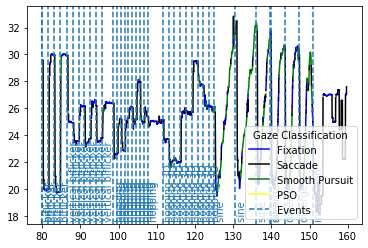

In [9]:
dis_seg_class = continuous_to_discrete(df["Timestamp"], df["REMODNAV_Segment"], df["REMODNAV_Class"])
dis_events = continuous_to_discrete(df["Timestamp"], df["Event_Idx"], df["Event_Name"])
plot_segmentation(df["Theta"], df["Timestamp"], dis_seg_class, dis_events)

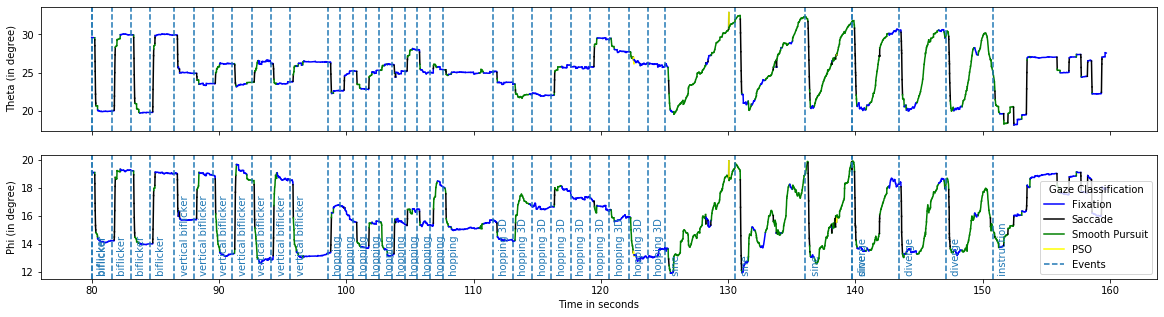

In [10]:
dis_seg_class = continuous_to_discrete(df["Timestamp"],
                                       df["NSLR_Segment"],
                                       df["NSLR_Class"])
dis_events = continuous_to_discrete(df["Timestamp"], df["Event_Idx"],
                                    df["Event_Name"])

fig, axes = plt.subplots(2, figsize=(20, 5), sharex=True)
        
plot_segmentation(df["Theta"], df["Timestamp"], dis_seg_class, dis_events, show_event_text=False, 
                  show_legend=False, ax=axes[0])
plot_segmentation(df["Phi"], df["Timestamp"], dis_seg_class, dis_events, ax=axes[1])

axes[0].set_ylabel("Theta (in degree)");
axes[1].set_ylabel("Phi (in degree)");   
axes[1].set_xlabel("Time in seconds");

Text(0, 0.5, 'Y Rotation in °')

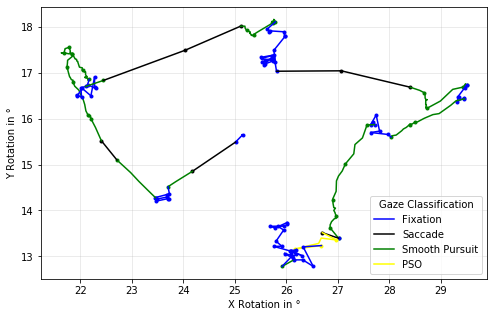

In [11]:
mask = df["Event_Name"] == "hopping 3D"
segments = continuous_to_discrete(df["Timestamp"], df["NSLR_Segment"], df["NSLR_Class"])


plt.figure(figsize=(8, 5))
plot_trajectory(df[mask]["Theta"], df[mask]["Phi"], df[mask]["Timestamp"], segments,
                show_legend=True, show_dots=True, show_clean=True, alpha_decay=0.,
                color_dict=None, ax=None, plot_kwargs=dict(linestyle="-"),
                dot_kwargs=dict(marker="."))
plt.grid(alpha=0.3)
plt.xlabel("X Rotation in °")
plt.ylabel("Y Rotation in °")

Text(0.5, 0, 'Time')

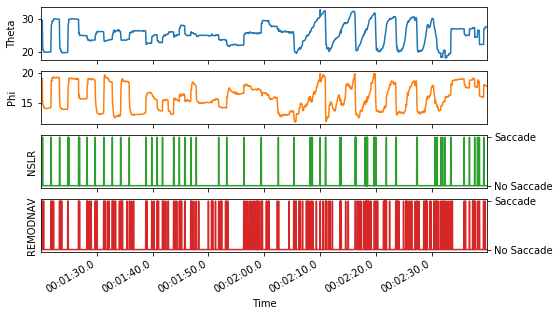

In [12]:
df["NSLR_SP"] = (df["NSLR_Class"] == "Saccade") * 1
df["REMODNAV_SP"] = (df["REMODNAV_Class"] == "Saccade") * 1
axes = df[["Theta", "Phi", "NSLR_SP", "REMODNAV_SP"]].plot(subplots=True, legend=False, figsize=(8, 5))


axes[2].yaxis.tick_right()
axes[2].set_yticklabels([0, "No Saccade", "Saccade"])
axes[3].yaxis.tick_right()
axes[3].set_yticklabels([0, "No Saccade", "Saccade"])
axes[0].set_ylabel("Theta")
axes[1].set_ylabel("Phi")
axes[2].set_ylabel("NSLR")
axes[3].set_ylabel("REMODNAV")
plt.xlabel("Time")

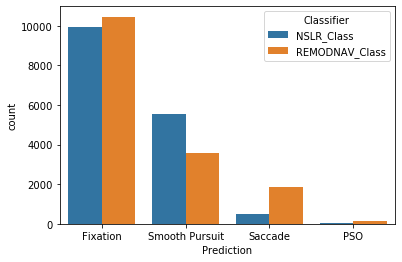

In [13]:
import seaborn as sns

df_melt = df[["NSLR_Class", "REMODNAV_Class"]].melt(var_name="Classifier",
                                                    value_name="Prediction")
sns.countplot(x="Prediction", hue="Classifier", data=df_melt)

/net/store/nbp/projects/MindQ/programming_tools/miniconda3/envs/mne/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/net/store/nbp/projects/MindQ/programming_tools/miniconda3/envs/mne/lib/python3.7/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/net/store/nbp/projects/MindQ/programming_tools/miniconda3/envs/mne/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misi

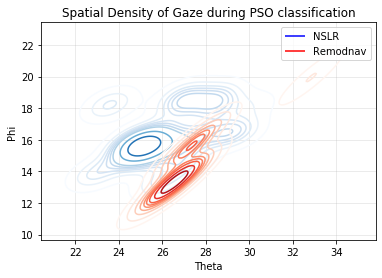

In [14]:
mask = df["REMODNAV_Class"] == "PSO"
sns.kdeplot(df[mask]["Theta"], df[mask]["Phi"], color='b',
            shade=False, cmap="Blues", shade_lowest=False)

mask = df["NSLR_Class"] == "PSO"
sns.kdeplot(df[mask]["Theta"], df[mask]["Phi"], color='b',
            shade=False, cmap="Reds", shade_lowest=False)

plt.title("Spatial Density of Gaze during PSO classification")
leg = plt.legend(["NSLR", "Remodnav"])
leg.legendHandles[0].set_color('blue')
leg.legendHandles[1].set_color('red')
plt.grid(alpha=0.3)

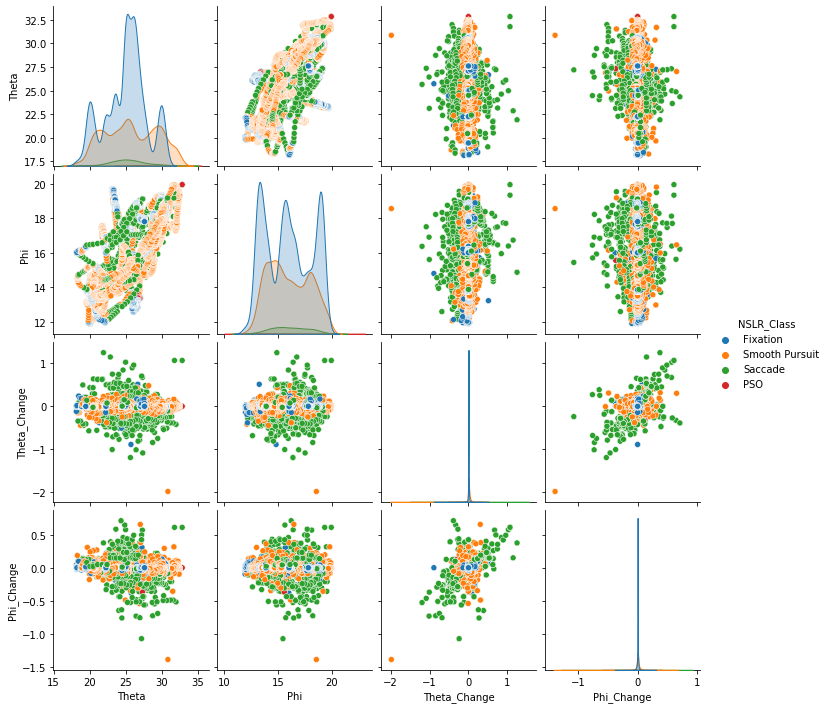

In [15]:
df["Theta_Change"] = df["Theta"] - df["Theta"].shift()
df["Phi_Change"] = df["Phi"] - df["Phi"].shift()
sns.pairplot(df[["Theta", "Phi", "Theta_Change", "Phi_Change", "NSLR_Class"]],
             hue="NSLR_Class")

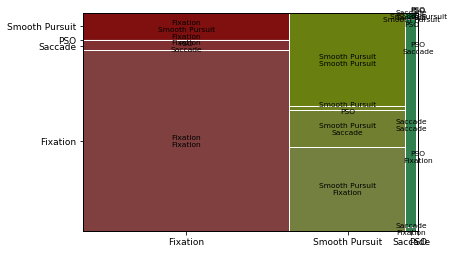

In [16]:
from statsmodels.graphics.mosaicplot import mosaic
plt.rcParams['font.size'] = 9.0
mosaic(df, ["NSLR_Class", "REMODNAV_Class"]);